In [88]:
from dealer.supplier import Csv
from time import time

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [77]:
from sklearn.base import BaseEstimator, TransformerMixin

class DefaultTransformer(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return self  

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return data[self.key]
    
class FeatureBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)
        
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    
    def transform(self, x, y=0):
        return self.encoder.transform(x)

In [78]:
master = Csv().read('data/master.csv')

train, test = Csv().read('data/train.csv'), Csv().read('data/test.csv')

print('Number of training samples: {}'.format(len(train)))
print('Number of testing samples: {}'.format(len(test)))

2018-09-13 16:36:16,012 | dealer.supplier.Csv      |     INFO | Reading data from CSV file
2018-09-13 16:36:16,024 | dealer.supplier.Csv      |     INFO | Reading complete, 0.01s
2018-09-13 16:36:16,029 | dealer.supplier.Csv      |     INFO | Reading data from CSV file
2018-09-13 16:36:16,033 | dealer.supplier.Csv      |     INFO | Reading complete, 0.0s
2018-09-13 16:36:16,038 | dealer.supplier.Csv      |     INFO | Reading data from CSV file
2018-09-13 16:36:16,042 | dealer.supplier.Csv      |     INFO | Reading complete, 0.0s


Number of training samples: 112
Number of testing samples: 38


In [79]:
train.groupby('gold_label')['target'].count()

gold_label
Iris-setosa        38
Iris-versicolor    37
Iris-virginica     37
Name: target, dtype: int64

In [108]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


features = ['sepal_length','sepal_width','petal_length','petal_width']

estimators = [
    KNeighborsClassifier(),
    GradientBoostingClassifier(),
    RandomForestClassifier(),
    RidgeClassifier(),
    SGDClassifier(),
    LinearSVC(),
    SVC(),
    LogisticRegression(),
    DecisionTreeClassifier()
]

In [109]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, KMeans
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline

pipelines = [
    ('no_preprocess', Pipeline([
        ('select', FeatureSelector(features))
    ])),
    ('normalize', Pipeline([
        ('select', FeatureSelector(features)),
        ('normalize', StandardScaler())
    ])),
    ('pca', Pipeline([
        ('select', FeatureSelector(features)),
        ('decomp', PCA(n_components=2))
    ])),
    ('pca_normalize', Pipeline([
        ('select', FeatureSelector(features)),
        ('normalize', StandardScaler()),
        ('decomp', PCA(n_components=2))
    ])),
    ('pca_union', Pipeline([
        ('union', FeatureUnion(
            transformer_list=[
                ('select', FeatureSelector(features)),
                ('decomp', Pipeline([
                    ('select', FeatureSelector(features)),
                    ('normalize', StandardScaler()),
                    ('pca', PCA(n_components=2))
                ]))
            ]
        ))
    ])),
    ('pca_kmeans', Pipeline([
        ('union', FeatureUnion(
            transformer_list=[
                ('select', FeatureSelector(features)),
                ('decomp_cluster', Pipeline([
                    ('select', FeatureSelector(features)),
                    ('decomp', PCA(n_components=2)),
                    ('cluster', KMeans(n_clusters=3))
                ]))
            ]
        ))
    ]))
]

In [110]:
from sklearn.base import clone
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score

models = []
for estimator in estimators:
    model_name = type(estimator).__name__.lower()
    for pipe_name, pipeline in pipelines:
#         print('[+] Starting {} with {}'.format(model_name, pipe_name))
        kfold = KFold(n_splits=5, random_state=0)
    
        start = time()
        
        pipes = clone(pipeline)
        pipes.steps.append(['estimator', estimator])
        
        _ = pipes.fit(train, train['target'])
        cv = cross_val_score(pipes, train, train['target'], cv=kfold, scoring='accuracy')
        train_time = time() - start
        
        y_pred = pipes.predict(test)
        accuracy = accuracy_score(test['target'], y_pred)
#         print('[+] Finished training in {}. Accuracy Score is {}'.format(round(train_time, 4), round(accuracy, 5)))
        
    
        models.append({
            'model_name': model_name,
            'model_desc': pipe_name,
            'accuracy_score': accuracy,
            'cv_mean': cv.mean(),
            'cv_std': cv.std(),
            'training_time': train_time
        })
        
#         print('')

/usr/local/Cellar/pyenv/1.2.6/versions/3.7.0/envs/venv-ds/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/Cellar/pyenv/1.2.6/versions/3.7.0/envs/venv-ds/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and de

/usr/local/Cellar/pyenv/1.2.6/versions/3.7.0/envs/venv-ds/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [111]:
best_models = sorted(models, key=lambda x: x['accuracy_score'], reverse=True)

for model in best_models[:10]:
    print('{} with {} had {} accuracy on test data. CV Results: {}, {}'.format(
        model['model_name'],
        model['model_desc'],
        round(model['accuracy_score'], 4) * 100,
        round(model['cv_mean'], 4),
        round(model['cv_std'], 4)
    ))

linearsvc with no_preprocess had 100.0 accuracy on test data. CV Results: 0.947, 0.0513
linearsvc with pca_kmeans had 100.0 accuracy on test data. CV Results: 0.9383, 0.044
kneighborsclassifier with normalize had 97.37 accuracy on test data. CV Results: 0.9289, 0.0534
kneighborsclassifier with pca had 97.37 accuracy on test data. CV Results: 0.9379, 0.0447
kneighborsclassifier with pca_union had 97.37 accuracy on test data. CV Results: 0.9289, 0.0534
kneighborsclassifier with pca_kmeans had 97.37 accuracy on test data. CV Results: 0.9292, 0.0444
gradientboostingclassifier with no_preprocess had 97.37 accuracy on test data. CV Results: 0.9206, 0.0576
gradientboostingclassifier with normalize had 97.37 accuracy on test data. CV Results: 0.9206, 0.0576
gradientboostingclassifier with pca_kmeans had 97.37 accuracy on test data. CV Results: 0.9032, 0.0884
randomforestclassifier with no_preprocess had 97.37 accuracy on test data. CV Results: 0.9115, 0.0669


In [115]:
best_model = Pipeline([
        ('select', FeatureSelector(features)),
        ('estimator', LinearSVC())
    ])

# best_model = Pipeline([
#     ('union', FeatureUnion(
#         transformer_list=[
#             ('select', FeatureSelector(features)),
#             ('decomp_cluster', Pipeline([
#                 ('select', FeatureSelector(features)),
#                 ('decomp', PCA(n_components=2)),
#                 ('cluster', KMeans(n_clusters=3))
#             ]))
#         ]
#     )),
#     ('estimator', LinearSVC())
# ])

_ = best_model.fit(train, train['target'])

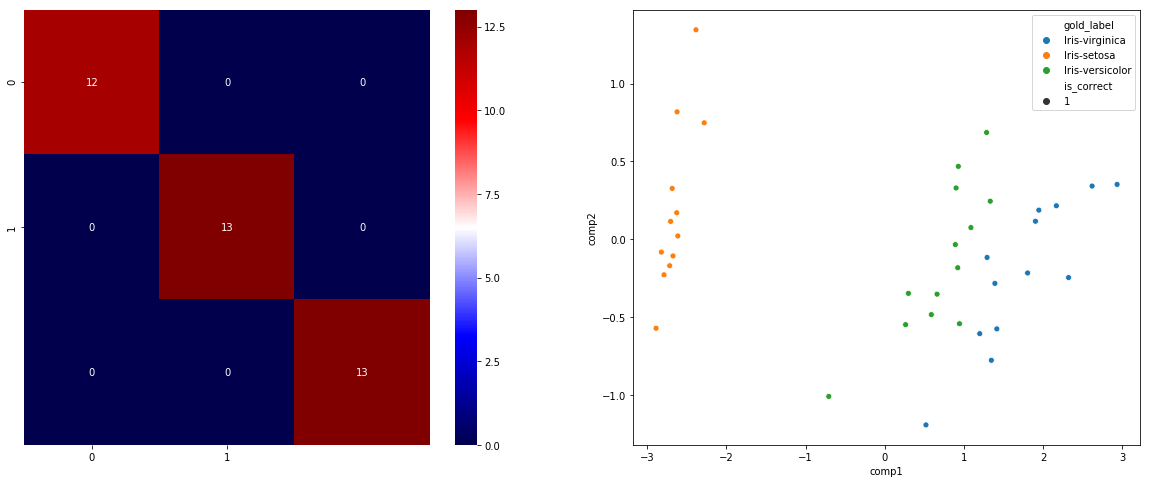

In [116]:
from sklearn.metrics import confusion_matrix, classification_report

fig, ax = plt.subplots(1, 2, figsize=(20, 8))

test['pred'] = best_model.predict(test)
test['incorrect'] = test.apply(lambda r: 0 if r['target'] == r['pred'] else 1, axis=1)

cnf = confusion_matrix(test['target'], test['pred'])
_ = sns.heatmap(cnf, xticklabels=[0,1], yticklabels=[0,1], annot=True, cmap="seismic", fmt="d", ax=ax[0])

_ = sns.scatterplot(x='comp1', y='comp2', data=test, hue='gold_label', style='is_correct', ax=ax[1])

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        50
          1       0.98      0.94      0.96        50
          2       0.94      0.98      0.96        50

avg / total       0.97      0.97      0.97       150



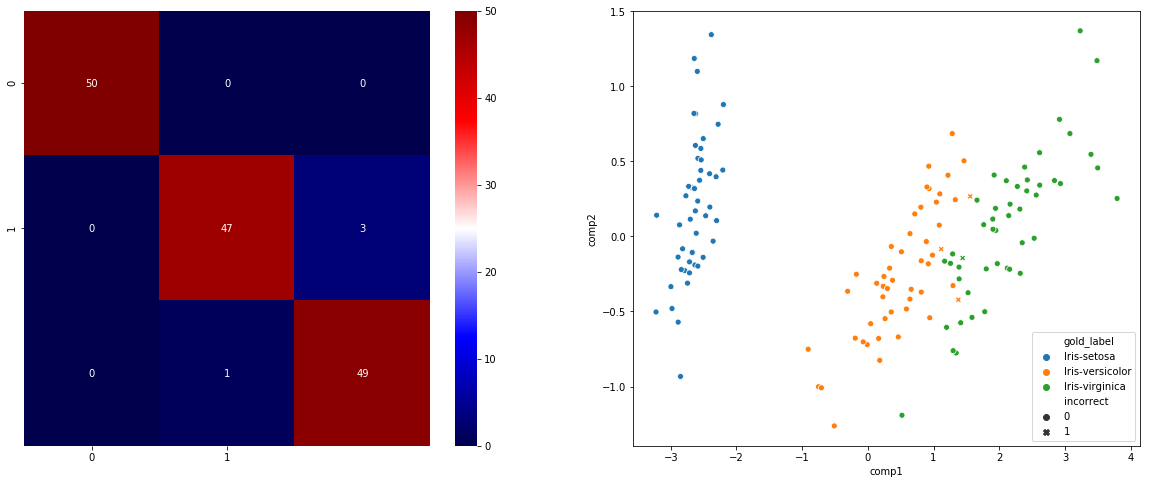

In [119]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

master['pred'] = best_model.predict(master)
master['incorrect'] = master.apply(lambda r: 0 if r['target'] == r['pred'] else 1, axis=1)

cnf = confusion_matrix(master['target'], master['pred'])
_ = sns.heatmap(cnf, xticklabels=[0,1], yticklabels=[0,1], annot=True, cmap="seismic", fmt="d", ax=ax[0])

_ = sns.scatterplot(x='comp1', y='comp2', data=master, hue='gold_label', style='incorrect', ax=ax[1])

print(classification_report(master['target'], master['pred']))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        50
          1       0.98      0.94      0.96        50
          2       0.94      0.98      0.96        50

avg / total       0.97      0.97      0.97       150



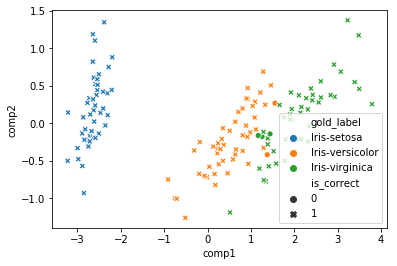

In [75]:
_ = sns.scatterplot(x='comp1', y='comp2', data=master, hue='gold_label', style='is_correct')

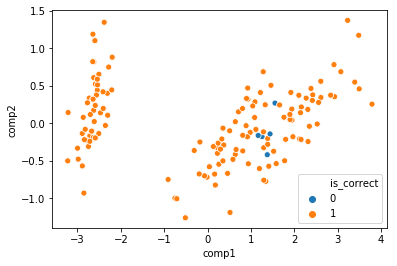

In [71]:
_ = sns.scatterplot(x='comp1', y='comp2', data=master, hue='is_correct')

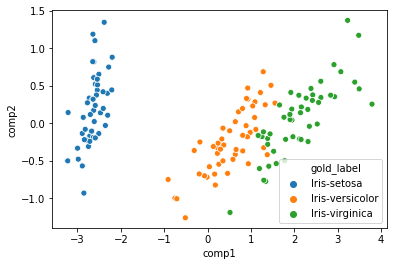

In [70]:
_ = sns.scatterplot(x='comp1', y='comp2', data=master, hue='gold_label')